(faster_sampling_notebook)=

# Faster Sampling with JAX and Numba

:::{post} July 11, 2023
:tags: hierarchical model, JAX, numba, scaling
:category: reference, intermediate
:author: Thomas Wiecki
:::

PyMC offers multiple sampling backends that can dramatically improve performance depending on your model size and requirements. Each backend has distinct advantages and is optimized for different use cases.

### PyMC's Built-in Sampler

```python
pm.sample()
```

The default PyMC sampler uses a Python-based NUTS implementation that provides maximum compatibility with all PyMC features. This sampler is required when working with models that contain discrete variables, as it's the only option that supports non-gradient based samplers like Slice and Metropolis. While this sampler can compile the underlying model to different backends (C, Numba, or JAX) using PyTensor's compilation system via the `compile_kwargs` parameter, it maintains Python overhead that can limit performance for large models.

### Nutpie Sampler

```python
pm.sample(nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "numba"})
pm.sample(nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax"})
pm.sample(nuts_sampler="nutpie", nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "pytensor"})
```

Nutpie is PyMC's cutting-edge performance sampler. Written in Rust, it eliminates Python overhead and provides exceptional performance for continuous models. The Numba backend typically offers the highest performance for most use cases, while the JAX backend excels with very large models and provides GPU acceleration capabilities. Nutpie is particularly well-suited for production workflows where sampling speed is critical.

### NumPyro Sampler

```python
pm.sample(nuts_sampler="numpyro", nuts_sampler_kwargs={"chain_method": "parallel"})
# GPU-accelerated
pm.sample(nuts_sampler="numpyro", nuts_sampler_kwargs={"chain_method": "vectorized"})
```

NumPyro provides a mature JAX-based sampling implementation that integrates seamlessly with the broader JAX ecosystem. This sampler benefits from years of development within the JAX community and provides reliable performance characteristics, with excellent GPU support for accelerated computation.

### BlackJAX Sampler

```python
pm.sample(nuts_sampler="blackjax")
```

BlackJAX offers another JAX-based sampling implementation focused on flexibility and research applications. While it provides similar capabilities to NumPyro, it's less commonly used in production environments. BlackJAX can be valuable for experimental workflows or when specific JAX-based features are required.

## Installation Requirements

To use the various sampling backends, you need to install the corresponding packages. Nutpie is the recommended high-performance option and can be installed with pip or conda/mamba (e.g. `conda install nutpie`). For JAX-based workflows, NumPyro provides mature functionality and is installed with the `numpyro` package. BlackJAX offers an alternative JAX implementation and is available in the `blackjax` package.

## Performance Guidelines

Understanding when to use each sampler depends on several key factors including model size, variable types, and computational requirements.

For **small models**, NumPyro typically provides the best balance of performance and reliability. The compilation overhead is minimal, and its mature JAX implementation handles these models efficiently. **Large models** generally perform best with Nutpie's Numba backend for consistent CPU performance or Nutpie's JAX backend when GPU acceleration is needed or memory efficiency is critical.

Models containing **discrete variables** must use PyMC's built-in sampler, as it's the only implementation that supports compatible (*i.e.*, non-gradient based) sampling algorithms. For purely continuous models, all sampling backends are available, making performance the primary consideration.

**Numba** excels at CPU optimization and provides consistent performance across different model types. It's particularly effective for models with complex mathematical operations that benefit from just-in-time compilation. **JAX** offers superior performance for very large models and provides natural GPU acceleration, making it ideal when computational resources are a limiting factor. The **C** backend serves as a reliable fallback option with broad compatibility but typically offers lower performance than the alternatives.

In [1]:
import time

from collections import defaultdict

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import pymc as pm

numpyro.set_host_device_count(4)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

rng = np.random.default_rng(seed=42)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.22.0


In [2]:
import time

from collections import defaultdict

# Dictionary to store all results
results = defaultdict(dict)


class TimingContext:
    def __init__(self, name):
        self.name = name

    def __enter__(self):
        self.start_wall = time.perf_counter()
        self.start_cpu = time.process_time()
        return self

    def __exit__(self, *args):
        self.end_wall = time.perf_counter()
        self.end_cpu = time.process_time()

        wall_time = self.end_wall - self.start_wall
        cpu_time = self.end_cpu - self.start_cpu

        results[self.name]["wall_time"] = wall_time
        results[self.name]["cpu_time"] = cpu_time

        print(f"Wall time: {wall_time:.1f} s")
        print(f"CPU time: {cpu_time:.1f} s")

In [3]:
def build_toy_dataset(N, D, K, sigma=1):
    x_train = np.zeros((D, N))
    w = rng.normal(
        0.0,
        2.0,
        size=(D, K),
    )
    z = rng.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    for d in range(D):
        for n in range(N):
            x_train[d, n] = rng.normal(mean[d, n], sigma)

    print("True principal axes:")
    print(w)
    return x_train


N = 5000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

data = build_toy_dataset(N, D, K)

True principal axes:
[[ 0.60943416]
 [-2.07996821]]


Text(0.5, 1.0, 'Simulated data set')

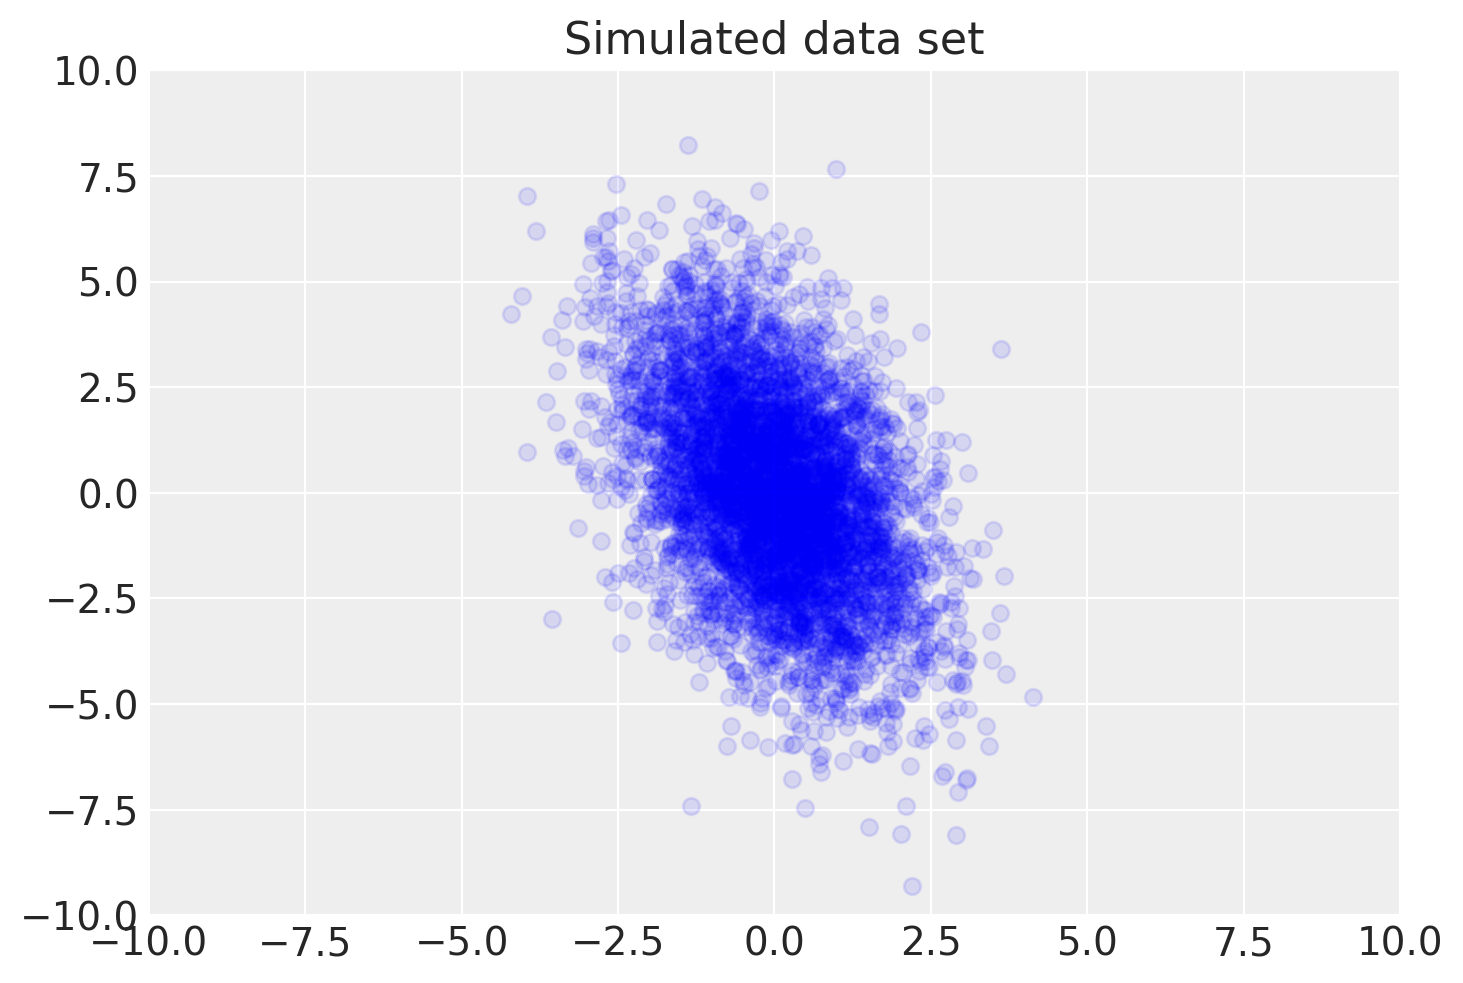

In [4]:
plt.scatter(data[0, :], data[1, :], color="blue", alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")

In [5]:
def ppca_model():
    with pm.Model() as model:
        w = pm.Normal(
            "w", mu=0, sigma=2, shape=[D, K], transform=pm.distributions.transforms.Ordered()
        )
        z = pm.Normal("z", mu=0, sigma=1, shape=[N, K])
        x = pm.Normal("x", mu=w.dot(z.T), sigma=1, shape=[D, N], observed=data)
    return model

## Performance Comparison

Now let's compare the performance of different sampling backends on our PPCA model. We'll measure both compilation time and sampling speed.

### 1. PyMC Default Sampler (Python NUTS)

In [6]:
n_draws = 2000
n_tune = 2000

with TimingContext("PyMC Default"):
    with ppca_model():
        idata_pymc = pm.sample(draws=n_draws, tune=n_tune, progressbar=False)

ess_pymc = az.ess(idata_pymc)
min_ess = min([ess_pymc[var].values.min() for var in ess_pymc.data_vars])
mean_ess = np.mean([ess_pymc[var].values.mean() for var in ess_pymc.data_vars])
results["PyMC Default"]["min_ess"] = min_ess
results["PyMC Default"]["mean_ess"] = mean_ess
print(f"Min ESS: {min_ess:.0f}, Mean ESS: {mean_ess:.0f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, z]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Wall time: 34.3 s
CPU time: 26.4 s
Min ESS: 6, Mean ESS: 191


### 2. Nutpie Sampler with Numba Backend

In [7]:
with TimingContext("Nutpie Numba"):
    with ppca_model():
        idata_nutpie_numba = pm.sample(
            draws=n_draws,
            tune=n_tune,
            nuts_sampler="nutpie",
            nuts_sampler_kwargs={"backend": "numba"},
            progressbar=False,
        )

ess_nutpie_numba = az.ess(idata_nutpie_numba)
min_ess = min([ess_nutpie_numba[var].values.min() for var in ess_nutpie_numba.data_vars])
mean_ess = np.mean([ess_nutpie_numba[var].values.mean() for var in ess_nutpie_numba.data_vars])
results["Nutpie Numba"]["min_ess"] = min_ess
results["Nutpie Numba"]["mean_ess"] = mean_ess
print(f"Min ESS: {min_ess:.0f}, Mean ESS: {mean_ess:.0f}")

Wall time: 34.3 s
CPU time: 53.0 s
Min ESS: 7, Mean ESS: 259


### 3. Nutpie Sampler with JAX Backend

In [8]:
with TimingContext("Nutpie JAX"):
    with ppca_model():
        idata_nutpie_jax = pm.sample(
            draws=n_draws,
            tune=n_tune,
            nuts_sampler="nutpie",
            nuts_sampler_kwargs={"backend": "jax"},
            progressbar=False,
        )

ess_nutpie_jax = az.ess(idata_nutpie_jax)
min_ess = min([ess_nutpie_jax[var].values.min() for var in ess_nutpie_jax.data_vars])
mean_ess = np.mean([ess_nutpie_jax[var].values.mean() for var in ess_nutpie_jax.data_vars])
results["Nutpie JAX"]["min_ess"] = min_ess
results["Nutpie JAX"]["mean_ess"] = mean_ess
print(f"Min ESS: {min_ess:.0f}, Mean ESS: {mean_ess:.0f}")

Wall time: 30.7 s
CPU time: 78.3 s
Min ESS: 7, Mean ESS: 261


### 4. NumPyro Sampler

In [9]:
with TimingContext("NumPyro"):
    with ppca_model():
        idata_numpyro = pm.sample(
            draws=n_draws, tune=n_tune, nuts_sampler="numpyro", progressbar=False
        )

ess_numpyro = az.ess(idata_numpyro)
min_ess = min([ess_numpyro[var].values.min() for var in ess_numpyro.data_vars])
mean_ess = np.mean([ess_numpyro[var].values.mean() for var in ess_numpyro.data_vars])
results["NumPyro"]["min_ess"] = min_ess
results["NumPyro"]["mean_ess"] = mean_ess
print(f"Min ESS: {min_ess:.0f}, Mean ESS: {mean_ess:.0f}")

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Wall time: 38.7 s
CPU time: 78.0 s
Min ESS: 7, Mean ESS: 423


In [10]:
timing_data = []
for backend_name, metrics in results.items():
    wall_time = metrics.get("wall_time", 0)
    cpu_time = metrics.get("cpu_time", 0)
    min_ess = metrics.get("min_ess", 0)
    mean_ess = metrics.get("mean_ess", 0)
    ess_per_sec = mean_ess / wall_time if wall_time > 0 else 0

    timing_data.append(
        {
            "Sampling Backend": backend_name,
            "Wall Time (s)": f"{wall_time:.1f}",
            "CPU Time (s)": f"{cpu_time:.1f}",
            "Min ESS": f"{min_ess:.0f}",
            "Mean ESS": f"{mean_ess:.0f}",
            "ESS/sec": f"{ess_per_sec:.0f}",
            "Parallel Efficiency": f"{cpu_time/wall_time:.2f}" if wall_time > 0 else "N/A",
        }
    )

timing_df = pd.DataFrame(timing_data)
timing_df = timing_df.sort_values("ESS/sec", ascending=False)

print("\nPerformance Summary Table:")
print("=" * 100)
print(timing_df.to_string(index=False))
print("=" * 100)

best_backend = timing_df.iloc[0]["Sampling Backend"]
best_ess_per_sec = timing_df.iloc[0]["ESS/sec"]
print(f"\nMost efficient backend: {best_backend} with {best_ess_per_sec} ESS/second")


Performance Summary Table:
Sampling Backend Wall Time (s) CPU Time (s) Min ESS Mean ESS ESS/sec Parallel Efficiency
      Nutpie JAX          30.7         78.3       7      261       9                2.55
    Nutpie Numba          34.3         53.0       7      259       8                1.55
    PyMC Default          34.3         26.4       6      191       6                0.77
         NumPyro          38.7         78.0       7      423      11                2.01

Most efficient backend: Nutpie JAX with 9 ESS/second


/tmp/ipykernel_1338684/3704666095.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


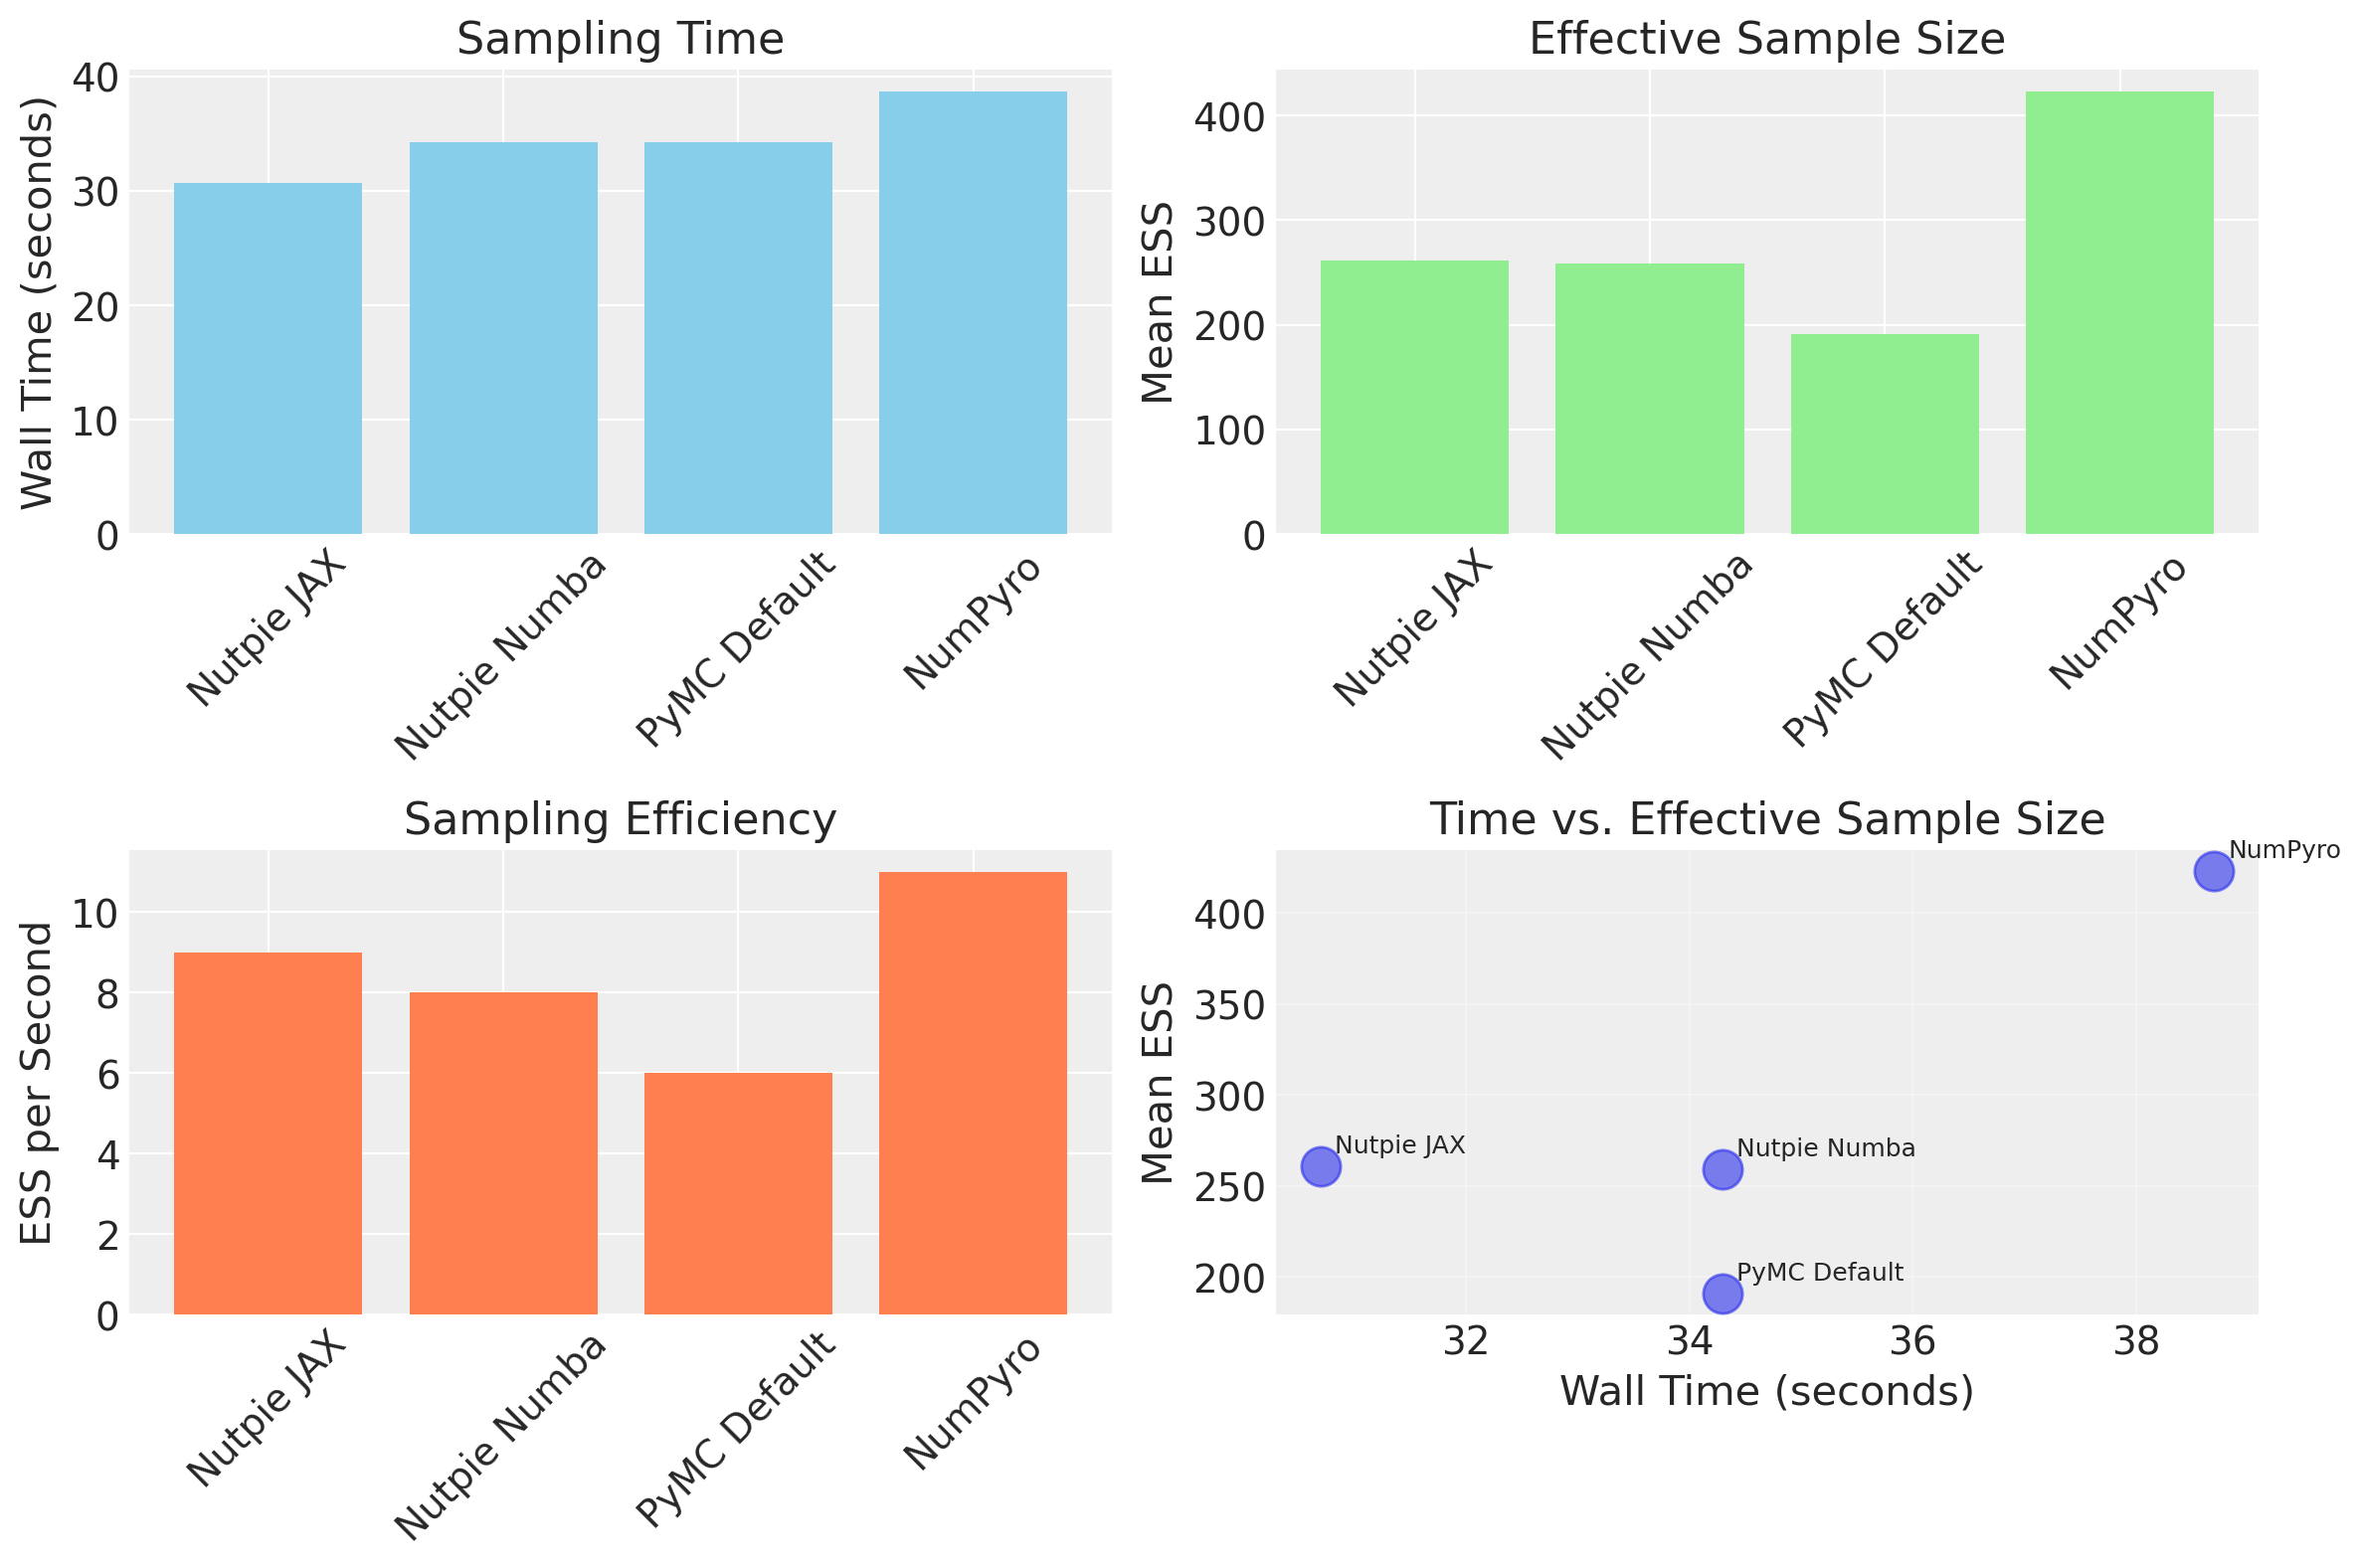

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

backends = timing_df["Sampling Backend"].tolist()
wall_times = [float(val) for val in timing_df["Wall Time (s)"].tolist()]
mean_ess_values = [float(val) for val in timing_df["Mean ESS"].tolist()]
ess_per_sec_values = [float(val) for val in timing_df["ESS/sec"].tolist()]

ax1.bar(backends, wall_times, color="skyblue")
ax1.set_ylabel("Wall Time (seconds)")
ax1.set_title("Sampling Time")
ax1.tick_params(axis="x", rotation=45)

ax2.bar(backends, mean_ess_values, color="lightgreen")
ax2.set_ylabel("Mean ESS")
ax2.set_title("Effective Sample Size")
ax2.tick_params(axis="x", rotation=45)

ax3.bar(backends, ess_per_sec_values, color="coral")
ax3.set_ylabel("ESS per Second")
ax3.set_title("Sampling Efficiency")
ax3.tick_params(axis="x", rotation=45)

ax4.scatter(wall_times, mean_ess_values, s=200, alpha=0.6)
for i, backend in enumerate(backends):
    ax4.annotate(
        backend,
        (wall_times[i], mean_ess_values[i]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
    )
ax4.set_xlabel("Wall Time (seconds)")
ax4.set_ylabel("Mean ESS")
ax4.set_title("Time vs. Effective Sample Size")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Special Cases and Advanced Usage

### Using PyMC's Built-in Sampler with Different Backends

In certain scenarios, you may need to use PyMC's Python-based sampler while still benefiting from faster computational backends. This situation commonly arises when working with models that contain discrete variables, which require PyMC's specialized sampling algorithms. Even in these cases, you can significantly improve performance by compiling the model's computational graph to more efficient backends.

The following examples demonstrate how to use PyMC's built-in sampler with different compilation targets. The `fast_run` mode uses optimized C compilation, which provides good performance while maintaining full compatibility. The `numba` mode offers the only way to access Numba's just-in-time compilation benefits when using PyMC's sampler. The `jax` mode enables JAX compilation, though for JAX workflows, Nutpie or NumPyro typically provide better performance.

In [12]:
with ppca_model():
    idata_c = pm.sample(nuts_sampler="pymc", compile_kwargs={"mode": "fast_run"}, progressbar=False)

# with ppca_model():
#     idata_pymc_numba = pm.sample(nuts_sampler="pymc", compile_kwargs={"mode": "numba"}, progressbar=False)

# with ppca_model():
#     idata_pymc_jax = pm.sample(nuts_sampler="pymc", compile_kwargs={"mode": "jax"}, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, z]
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some paramet

The above examples are commented out to avoid redundant sampling in this demonstration notebook. In practice, you would uncomment and run the configuration that matches your model's requirements. These compilation modes allow you to access faster computational backends even when you must use PyMC's Python-based sampler for compatibility reasons.

### Models with Discrete Variables

When working with models that contain discrete variables, you have no choice but to use PyMC's built-in sampler. This is because discrete variables require specialized sampling algorithms like Slice sampling or Metropolis-Hastings that are only available in PyMC's Python implementation. The example below demonstrates a typical scenario where this constraint applies.

In [13]:
with pm.Model() as discrete_model:
    cluster = pm.Categorical("cluster", p=[0.3, 0.7], shape=100)
    mu = pm.Normal("mu", 0, 1, shape=2)
    sigma = pm.HalfNormal("sigma", 1, shape=2)
    obs = pm.Normal("obs", mu=mu[cluster], sigma=sigma[cluster], observed=rng.normal(0, 1, 100))

    trace_discrete = pm.sample(progressbar=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [cluster]
>NUTS: [mu, sigma]
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903

## Authors

- Originally authored by Thomas Wiecki in July 2023  
- Updated and expanded by Chris Fonnesbeck in May 2025

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,arviz,pymc,numpyro,blackjax,nutpie

Last updated: Wed May 28 2025

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.2.0

pytensor: 2.30.3
arviz   : 0.21.0
pymc    : 5.22.0
numpyro : 0.18.0
blackjax: 0.0.0
nutpie  : 0.14.3

numpyro   : 0.18.0
pymc      : 5.22.0
matplotlib: 3.10.3
numpy     : 2.2.6
pandas    : 2.2.3
arviz     : 0.21.0

Watermark: 2.5.0

